In [1]:
# Standard Libraries
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deep Learning and PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
# Image Processing
from PIL import Image
from torchvision import transforms, models

# File Handling
import h5py

# Metrics and Evaluation
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# Progress Visualization
from tqdm import tqdm



## Create Custom Dataset

In [2]:

class MultiInputDataset(Dataset):
    def __init__(self, hdf5_file, csv_file, transform=None):
        # Open the HDF5 file with error handling
        try:
            self.hdf5_file = h5py.File(hdf5_file, 'r')  # Read-only mode
        except Exception as e:
            raise IOError(f"Could not open HDF5 file: {hdf5_file}. Error: {e}")

        # Read the CSV file containing image labels and additional features
        try:
            self.labels_df = pd.read_csv(csv_file)
        except Exception as e:
            raise IOError(f"Could not read CSV file: {csv_file}. Error: {e}")

        # Ensure that all image IDs from the CSV are present in the HDF5 file
        self.image_ids = self.labels_df['isic_id'].values
        for image_id in self.image_ids:
            if str(image_id) not in self.hdf5_file.keys():
                raise ValueError(f"Image id {image_id} not found in HDF5 file.")

        # Store any transformations to be applied to the images
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Get the image ID from the CSV file based on index
        image_id = str(self.labels_df.iloc[idx]['isic_id'])

        # Load the image data from the HDF5 file
        image_bytes = self.hdf5_file[image_id][()]

        # Convert the image bytes to a PIL Image
        image = Image.open(io.BytesIO(image_bytes))

        # Apply any specified transformations to the image
        if self.transform:
            image = self.transform(image)

        # Retrieve the label
        label = torch.tensor(self.labels_df.iloc[idx]['target'], dtype=torch.long)  # Adjust dtype if needed

        # Retrieve other features, excluding 'isic_id' and 'target'
        other_variables = self.labels_df.iloc[idx].drop(['isic_id', 'target']).values.astype(float)

        # Convert other variables (metadata) to a tensor
        metadata_tensor = torch.tensor(other_variables, dtype=torch.float32)

        # Return the image, metadata, and label
        return image, metadata_tensor, label


In [3]:
# Define any necessary transformations for the image dataset


# Transformations for training set (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 225x225
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop to 225x225 with scale
    transforms.RandomRotation(10),  # Randomly rotate images by 10 degrees
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Transformations for validation/test set (no data augmentation)
normal_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure the image is resized to 225x225
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])




## Train DataLoader

In [4]:
# Initialize the dataset
train_dataset = MultiInputDataset(hdf5_file='../data/raw/train_images.hdf5', csv_file='../data/processed/processed-train-metadata1.csv', transform=normal_transform)
val_dataset = MultiInputDataset(hdf5_file='../data/raw/validation_image.hdf5', csv_file='../data/processed/processed-validation-metadata1.csv', transform=normal_transform)
# Create a DataLoader
train_dataloader = DataLoader(train_dataset,  batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset,  batch_size=64, shuffle=True)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model Building

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class CustomImageFeatureEfficientNet(nn.Module):
    def __init__(self, feature_input_size, pretrained=True):
        super(CustomImageFeatureEfficientNet, self).__init__()

        # Load a pretrained EfficientNet model for image feature extraction (EfficientNet-B0 in this case)
        efficientnet = models.efficientnet_b0(pretrained=pretrained)  # You can change this to another EfficientNet version like B1 or B7
        self.efficientnet = nn.Sequential(*list(efficientnet.children())[:-1])  # Remove the final classification layer

        # The output of EfficientNet-B0's last conv layer is 1280-dimensional
        self.fc_image = nn.Linear(1280, 512)  # Reduce dimension to match your custom architecture

        # Fully connected layer for metadata (feature data)
        self.fc_metadata = nn.Linear(feature_input_size, 128)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)  # 50% dropout

        # Final fully connected layer for binary classification (combined image + feature input)
        self.fc_combined = nn.Linear(512 + 128, 1)  # For binary classification

    def forward(self, image, metadata):
        # Forward pass for the image through EfficientNet (without the final classification layer)
        x = self.efficientnet(image)  # EfficientNet feature extraction
        x = x.view(x.size(0), -1)  # Flatten the EfficientNet output
        image_features = F.relu(self.fc_image(x))

        # Process metadata (feature data)
        metadata_features = F.relu(self.fc_metadata(metadata))

        # Ensure the batch sizes are consistent
        assert image_features.shape[0] == metadata_features.shape[0], \
            f"Batch sizes do not match! Image batch size: {image_features.shape[0]}, Metadata batch size: {metadata_features.shape[0]}"

        # Concatenate image features and metadata features
        combined_features = torch.cat((image_features, metadata_features), dim=1)

        # Dropout and final classification layer
        combined_features = self.dropout(combined_features)
        output = self.fc_combined(combined_features)

        # If you're using BCELoss, uncomment the next line to apply sigmoid
        output = torch.sigmoid(output)

        return output


## Model Training

In [7]:
# Function to compute partial AUC-above-TPR
def score(solution: np.array, submission: np.array, min_tpr: float = 0.80) -> float:
    """
    Compute the partial AUC by focusing on a specific range of true positive rates (TPR).
    
    Args:
        solution (np.array): Ground truth binary labels.
        submission (np.array): Model predictions.
        min_tpr (float): Minimum true positive rate to calculate partial AUC.
    
    Returns:
        float: The calculated partial AUC.
    
    Raises:
        ValueError: If the min_tpr is not within a valid range.
    """
    # Rescale the target to handle sklearn limitations and flip the predictions
    v_gt = abs(solution - 1)
    v_pred = -1.0 * submission
    max_fpr = abs(1 - min_tpr)

    # Compute ROC curve using sklearn
    fpr, tpr, _ = roc_curve(v_gt, v_pred)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError(f"Expected min_tpr in range [0, 1), got: {min_tpr}")
    
    # Interpolate for partial AUC
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    
    return partial_auc

# Training and validation loop function
def train_and_validate(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    early_stopping_patience: int = 5,
    min_tpr: float = 0.80
) -> nn.Module:
    """
    Train and validate a PyTorch model with early stopping, AUROC, partial AUC, and error handling.

    Args:
        model (nn.Module): The model to be trained and validated.
        train_dataloader (torch.utils.data.DataLoader): Dataloader for training data.
        val_dataloader (torch.utils.data.DataLoader): Dataloader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer to update the model.
        epochs (int): Number of training epochs.
        device (torch.device): The device (CPU or GPU) to use.
        early_stopping_patience (int): Early stopping patience.
        min_tpr (float): The minimum true positive rate for calculating partial AUC.
    
    Returns:
        nn.Module: The trained model.
    """
    # Initialize tracking variables
    best_val_loss = float('inf')
    best_epoch = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping_counter = 0

    # Start the training and validation loop
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        all_train_labels = []
        all_train_probs = []

        progress_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}')

        try:
            # Loop through the training batches
            for i, (image, metadata, labels) in enumerate(progress_bar):
                image, metadata, labels = image.to(device), metadata.to(device), labels.float().to(device)
                labels = labels.unsqueeze(1)  # Adjust labels to have the right shape for binary classification

                optimizer.zero_grad()

                # Forward pass
                probs = model(image, metadata)

                if probs.shape != labels.shape:
                    raise ValueError(f"Shape mismatch: Predictions shape {probs.shape} does not match labels shape {labels.shape}")

                # Calculate loss and backpropagate
                loss = criterion(probs, labels)
                loss.backward()
                optimizer.step()

                # Update running loss
                running_train_loss += loss.item()

                # Store labels and predictions for accuracy calculations
                all_train_labels.extend(labels.cpu().detach().numpy())
                all_train_probs.extend(probs.cpu().detach().numpy())

                # Calculate binary predictions for training accuracy
                predicted_train = (probs >= 0.5).float()
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()

                # Update progress bar
                progress_bar.set_postfix(train_loss=running_train_loss / (i + 1))

            # Calculate training accuracy and loss
            train_accuracy = 100 * correct_train / total_train
            train_losses.append(running_train_loss / len(train_dataloader))
            train_accuracies.append(train_accuracy)

        except ValueError as ve:
            print(f"Error during training loop: {ve}")
            break

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []

        progress_bar = tqdm(val_dataloader, desc=f'Validating Epoch {epoch + 1}')

        with torch.no_grad():
            try:
                # Loop through the validation batches
                for i, (images, metadata, labels) in enumerate(progress_bar):
                    images, metadata, labels = images.to(device), metadata.to(device), labels.float().to(device)
                    labels = labels.unsqueeze(1)

                    probs = model(images, metadata)

                    loss = criterion(probs, labels)
                    running_val_loss += loss.item()

                    all_labels.extend(labels.cpu().detach().numpy())
                    all_probs.extend(probs.cpu().detach().numpy())

                    # Calculate binary predictions for validation accuracy
                    predicted = (probs >= 0.5).float()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    progress_bar.set_postfix(val_loss=running_val_loss / (i + 1))

                val_accuracy = 100 * correct / total
                val_loss = running_val_loss / len(val_dataloader)
                val_accuracies.append(val_accuracy)
                val_losses.append(val_loss)

                # Calculate AUROC
                try:
                    valid_auroc = roc_auc_score(all_labels, all_probs)
                except ValueError as ve:
                    print(f"AUROC Calculation Error: {ve}")
                    valid_auroc = 0.0

                # Calculate partial AUC-above-TPR
                try:
                    partial_auroc = score(np.array(all_labels), np.array(all_probs), min_tpr=min_tpr)
                except ValueError as ve:
                    print(f"Partial AUC Calculation Error: {ve}")
                    partial_auroc = 0.0

                print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, '
                      f'Val Accuracy: {val_accuracy:.2f}%, Val AUROC: {valid_auroc:.4f}, Partial AUROC: {partial_auroc:.4f}')

                # Early stopping based on validation loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch + 1
                    early_stopping_counter = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    early_stopping_counter += 1

                if early_stopping_counter >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break

            except Exception as e:
                print(f"Error during validation loop: {e}")
                break

    print(f"Best Epoch: {best_epoch}, Best Validation Loss: {best_val_loss:.4f}")
    print('Training Complete')

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Generate classification report
    try:
        print("Classification Report:")
        print(classification_report(all_labels, (np.array(all_probs) >= 0.5).astype(int), target_names=['Class 0', 'Class 1']))
    except Exception as e:
        print(f"Error generating classification report: {e}")

    return model



## Model 1

In [8]:
model1 =  CustomImageFeatureEfficientNet(feature_input_size=9)  # Assuming 9 features for metadata
model1.to(device)
# Initialize optimizer
optimizer = optim.Adam(model1.parameters(), lr= 1.1621608010269284e-05)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
batch_sizes = 16

train_dataloader = DataLoader(train_dataset,  batch_size=batch_sizes, shuffle=True)
val_dataloader = DataLoader(val_dataset,  batch_size=batch_sizes, shuffle=True)


/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Validating Epoch 1: 100%|██████████| 94/94 [01:07<00:00,  1.40it/s, val_loss=0.55] 


Epoch [1/20], Train Loss: 0.6557, Val Loss: 0.5498, Val Accuracy: 92.48%, Val AUROC: 0.6143, Partial AUROC: 0.0387
Epoch 2/20


Validating Epoch 2: 100%|██████████| 94/94 [00:57<00:00,  1.64it/s, val_loss=0.422]


Epoch [2/20], Train Loss: 0.5737, Val Loss: 0.4218, Val Accuracy: 92.01%, Val AUROC: 0.7433, Partial AUROC: 0.0565
Epoch 3/20


Validating Epoch 3: 100%|██████████| 94/94 [00:40<00:00,  2.32it/s, val_loss=0.317]


Epoch [3/20], Train Loss: 0.4761, Val Loss: 0.3170, Val Accuracy: 92.21%, Val AUROC: 0.8123, Partial AUROC: 0.0790
Epoch 4/20


Validating Epoch 4: 100%|██████████| 94/94 [00:40<00:00,  2.32it/s, val_loss=0.263]


Epoch [4/20], Train Loss: 0.3991, Val Loss: 0.2633, Val Accuracy: 92.08%, Val AUROC: 0.8400, Partial AUROC: 0.0917
Epoch 5/20


Validating Epoch 5: 100%|██████████| 94/94 [00:42<00:00,  2.24it/s, val_loss=0.251]


Epoch [5/20], Train Loss: 0.3393, Val Loss: 0.2508, Val Accuracy: 90.67%, Val AUROC: 0.8569, Partial AUROC: 0.1019
Epoch 6/20


Validating Epoch 6: 100%|██████████| 94/94 [00:41<00:00,  2.24it/s, val_loss=0.227]


Epoch [6/20], Train Loss: 0.2924, Val Loss: 0.2267, Val Accuracy: 90.07%, Val AUROC: 0.8687, Partial AUROC: 0.1095
Epoch 7/20


Validating Epoch 7: 100%|██████████| 94/94 [00:51<00:00,  1.84it/s, val_loss=0.193]


Epoch [7/20], Train Loss: 0.2592, Val Loss: 0.1929, Val Accuracy: 92.75%, Val AUROC: 0.8605, Partial AUROC: 0.1050
Epoch 8/20


Validating Epoch 8: 100%|██████████| 94/94 [00:41<00:00,  2.25it/s, val_loss=0.267]


Epoch [8/20], Train Loss: 0.2260, Val Loss: 0.2668, Val Accuracy: 86.24%, Val AUROC: 0.8765, Partial AUROC: 0.1165
Epoch 9/20


Validating Epoch 9: 100%|██████████| 94/94 [00:49<00:00,  1.90it/s, val_loss=0.2]  


Epoch [9/20], Train Loss: 0.1948, Val Loss: 0.2004, Val Accuracy: 91.14%, Val AUROC: 0.8652, Partial AUROC: 0.1062
Epoch 10/20


Validating Epoch 10: 100%|██████████| 94/94 [00:51<00:00,  1.83it/s, val_loss=0.245]


Epoch [10/20], Train Loss: 0.1773, Val Loss: 0.2454, Val Accuracy: 88.39%, Val AUROC: 0.8726, Partial AUROC: 0.1106
Epoch 11/20


Validating Epoch 11: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s, val_loss=0.211]


Epoch [11/20], Train Loss: 0.1485, Val Loss: 0.2108, Val Accuracy: 90.60%, Val AUROC: 0.8619, Partial AUROC: 0.1064
Epoch 12/20


Validating Epoch 12: 100%|██████████| 94/94 [00:41<00:00,  2.25it/s, val_loss=0.206]


Epoch [12/20], Train Loss: 0.1338, Val Loss: 0.2058, Val Accuracy: 91.01%, Val AUROC: 0.8582, Partial AUROC: 0.1033
Early stopping triggered at epoch 12
Best Epoch: 7, Best Validation Loss: 0.1929
Training Complete


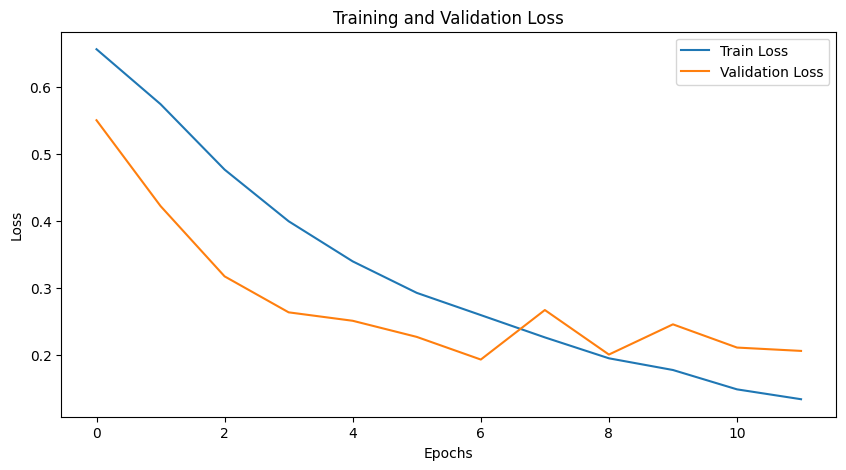

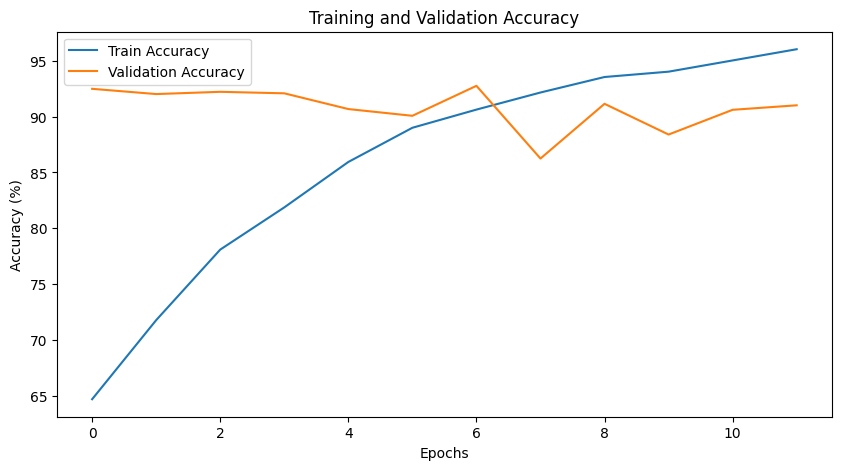

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.93      0.95      1431
     Class 1       0.22      0.51      0.31        59

    accuracy                           0.91      1490
   macro avg       0.60      0.72      0.63      1490
weighted avg       0.95      0.91      0.93      1490



CustomImageFeatureEfficientNet(
  (efficientnet): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
       

In [9]:
train_and_validate(model1,train_dataloader, val_dataloader, criterion, optimizer, epochs, device )

## Model 2

In [8]:
model2 = CustomImageFeatureEfficientNet(feature_input_size=9)  # Assuming 9 features for metadata
model2.to(device)
# Initialize optimizer
optimizer = optim.SGD(model2.parameters(), lr=0.01)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
batch_sizes = 16

/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
train_dataloader = DataLoader(train_dataset,  batch_size=batch_sizes, shuffle=True)
val_dataloader = DataLoader(val_dataset,  batch_size=batch_sizes, shuffle=True)

Epoch 1/20


Validating Epoch 1: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s, val_loss=0.43] 


Epoch [1/20], Train Loss: 0.6158, Val Loss: 0.4299, Val Accuracy: 95.23%, Val AUROC: 0.6865, Partial AUROC: 0.0289
Epoch 2/20


Validating Epoch 2: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s, val_loss=0.394]


Epoch [2/20], Train Loss: 0.5508, Val Loss: 0.3940, Val Accuracy: 93.96%, Val AUROC: 0.7499, Partial AUROC: 0.0437
Epoch 3/20


Validating Epoch 3: 100%|██████████| 94/94 [00:45<00:00,  2.07it/s, val_loss=0.374]


Epoch [3/20], Train Loss: 0.4873, Val Loss: 0.3735, Val Accuracy: 90.13%, Val AUROC: 0.7978, Partial AUROC: 0.0662
Epoch 4/20


Validating Epoch 4: 100%|██████████| 94/94 [00:42<00:00,  2.23it/s, val_loss=0.37] 


Epoch [4/20], Train Loss: 0.4153, Val Loss: 0.3697, Val Accuracy: 90.13%, Val AUROC: 0.8109, Partial AUROC: 0.0820
Epoch 5/20


Validating Epoch 5: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s, val_loss=0.314]


Epoch [5/20], Train Loss: 0.3559, Val Loss: 0.3136, Val Accuracy: 88.12%, Val AUROC: 0.8329, Partial AUROC: 0.0810
Epoch 6/20


Validating Epoch 6: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s, val_loss=0.258]


Epoch [6/20], Train Loss: 0.2868, Val Loss: 0.2583, Val Accuracy: 90.81%, Val AUROC: 0.8405, Partial AUROC: 0.0820
Epoch 7/20


Validating Epoch 7: 100%|██████████| 94/94 [00:42<00:00,  2.23it/s, val_loss=0.242]


Epoch [7/20], Train Loss: 0.2332, Val Loss: 0.2420, Val Accuracy: 90.47%, Val AUROC: 0.8521, Partial AUROC: 0.0878
Epoch 8/20


Validating Epoch 8: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s, val_loss=0.397]


Epoch [8/20], Train Loss: 0.2000, Val Loss: 0.3967, Val Accuracy: 79.19%, Val AUROC: 0.8120, Partial AUROC: 0.0802
Epoch 9/20


Validating Epoch 9: 100%|██████████| 94/94 [00:40<00:00,  2.31it/s, val_loss=0.425]


Epoch [9/20], Train Loss: 0.1610, Val Loss: 0.4249, Val Accuracy: 75.23%, Val AUROC: 0.8130, Partial AUROC: 0.0871
Epoch 10/20


Validating Epoch 10: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s, val_loss=0.244]


Epoch [10/20], Train Loss: 0.1353, Val Loss: 0.2439, Val Accuracy: 89.87%, Val AUROC: 0.8739, Partial AUROC: 0.1062
Epoch 11/20


Validating Epoch 11: 100%|██████████| 94/94 [00:41<00:00,  2.24it/s, val_loss=0.642]


Epoch [11/20], Train Loss: 0.1099, Val Loss: 0.6419, Val Accuracy: 70.87%, Val AUROC: 0.7527, Partial AUROC: 0.0498
Epoch 12/20


Validating Epoch 12: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s, val_loss=0.241]


Epoch [12/20], Train Loss: 0.1052, Val Loss: 0.2414, Val Accuracy: 91.28%, Val AUROC: 0.8585, Partial AUROC: 0.1001
Epoch 13/20


Validating Epoch 13: 100%|██████████| 94/94 [00:40<00:00,  2.29it/s, val_loss=0.203]


Epoch [13/20], Train Loss: 0.0961, Val Loss: 0.2032, Val Accuracy: 92.75%, Val AUROC: 0.8503, Partial AUROC: 0.0886
Epoch 14/20


Validating Epoch 14: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s, val_loss=0.249]


Epoch [14/20], Train Loss: 0.0780, Val Loss: 0.2486, Val Accuracy: 91.14%, Val AUROC: 0.8618, Partial AUROC: 0.1037
Epoch 15/20


Validating Epoch 15: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s, val_loss=0.269]


Epoch [15/20], Train Loss: 0.0776, Val Loss: 0.2688, Val Accuracy: 90.34%, Val AUROC: 0.8610, Partial AUROC: 0.1079
Epoch 16/20


Validating Epoch 16: 100%|██████████| 94/94 [00:41<00:00,  2.29it/s, val_loss=0.202]


Epoch [16/20], Train Loss: 0.0518, Val Loss: 0.2024, Val Accuracy: 92.55%, Val AUROC: 0.8864, Partial AUROC: 0.1228
Epoch 17/20


Validating Epoch 17: 100%|██████████| 94/94 [00:40<00:00,  2.31it/s, val_loss=0.217]


Epoch [17/20], Train Loss: 0.0600, Val Loss: 0.2168, Val Accuracy: 91.68%, Val AUROC: 0.8306, Partial AUROC: 0.0952
Epoch 18/20


Validating Epoch 18: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s, val_loss=0.223]


Epoch [18/20], Train Loss: 0.0471, Val Loss: 0.2227, Val Accuracy: 92.01%, Val AUROC: 0.8683, Partial AUROC: 0.1082
Epoch 19/20


Validating Epoch 19: 100%|██████████| 94/94 [00:40<00:00,  2.33it/s, val_loss=0.238]


Epoch [19/20], Train Loss: 0.0453, Val Loss: 0.2382, Val Accuracy: 92.68%, Val AUROC: 0.8362, Partial AUROC: 0.0833
Epoch 20/20


Validating Epoch 20: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s, val_loss=0.241]


Epoch [20/20], Train Loss: 0.0331, Val Loss: 0.2410, Val Accuracy: 92.01%, Val AUROC: 0.8047, Partial AUROC: 0.0742
Best Epoch: 16, Best Validation Loss: 0.2024
Training Complete


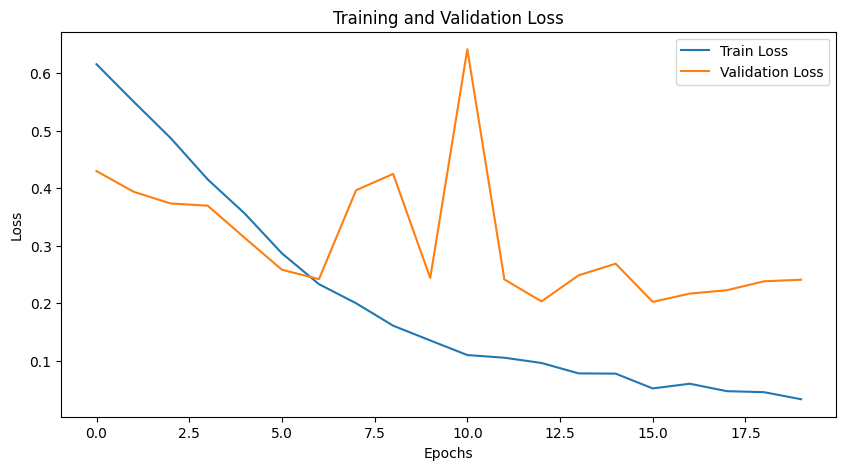

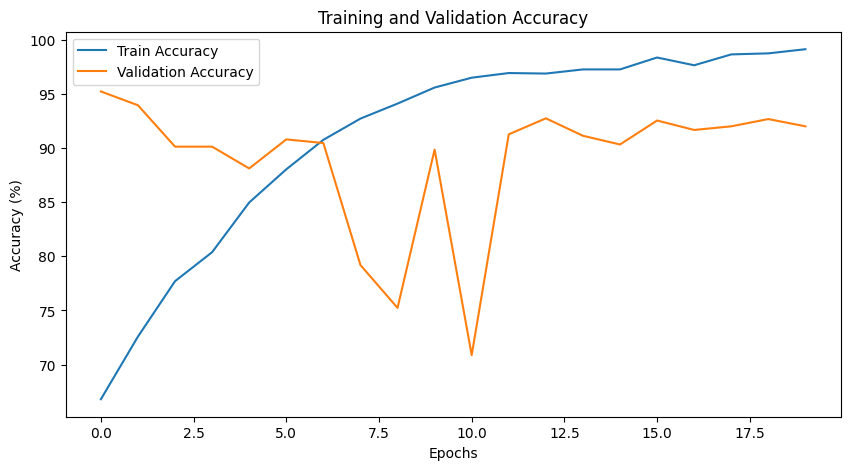

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.94      0.96      1431
     Class 1       0.24      0.47      0.32        59

    accuracy                           0.92      1490
   macro avg       0.61      0.71      0.64      1490
weighted avg       0.95      0.92      0.93      1490



CustomImageFeatureEfficientNet(
  (efficientnet): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
       

In [10]:

train_and_validate(model2,train_dataloader, val_dataloader, criterion, optimizer, epochs, device )

## Model 3

In [8]:
model3 = CustomImageFeatureEfficientNet(feature_input_size=9)  # Assuming 9 features for metadata
model3.to(device)
# Initialize optimizer
optimizer = optim.Adam(model3.parameters(), lr=0.001)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
batch_sizes = 16

/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_sizes, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_sizes, shuffle=True)

Epoch 1/20


Validating Epoch 1: 100%|██████████| 94/94 [00:40<00:00,  2.30it/s, val_loss=0.174]


Epoch [1/20], Train Loss: 0.4428, Val Loss: 0.1745, Val Accuracy: 92.15%, Val AUROC: 0.8655, Partial AUROC: 0.0987
Epoch 2/20


Validating Epoch 2: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s, val_loss=0.191]


Epoch [2/20], Train Loss: 0.3468, Val Loss: 0.1911, Val Accuracy: 93.76%, Val AUROC: 0.8673, Partial AUROC: 0.1102
Epoch 3/20


Validating Epoch 3: 100%|██████████| 94/94 [00:41<00:00,  2.26it/s, val_loss=0.247]


Epoch [3/20], Train Loss: 0.2223, Val Loss: 0.2474, Val Accuracy: 92.01%, Val AUROC: 0.8157, Partial AUROC: 0.0739
Epoch 4/20


Validating Epoch 4: 100%|██████████| 94/94 [00:42<00:00,  2.23it/s, val_loss=0.429]


Epoch [4/20], Train Loss: 0.1918, Val Loss: 0.4288, Val Accuracy: 82.89%, Val AUROC: 0.8685, Partial AUROC: 0.1105
Epoch 5/20


Validating Epoch 5: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s, val_loss=0.312]


Epoch [5/20], Train Loss: 0.1519, Val Loss: 0.3117, Val Accuracy: 85.70%, Val AUROC: 0.8659, Partial AUROC: 0.1042
Epoch 6/20


Validating Epoch 6: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s, val_loss=0.169] 


Epoch [6/20], Train Loss: 0.1155, Val Loss: 0.1691, Val Accuracy: 95.50%, Val AUROC: 0.8651, Partial AUROC: 0.0967
Epoch 7/20


Validating Epoch 7: 100%|██████████| 94/94 [00:41<00:00,  2.25it/s, val_loss=0.214] 


Epoch [7/20], Train Loss: 0.0595, Val Loss: 0.2139, Val Accuracy: 93.36%, Val AUROC: 0.8953, Partial AUROC: 0.1278
Epoch 8/20


Validating Epoch 8: 100%|██████████| 94/94 [00:41<00:00,  2.26it/s, val_loss=0.168] 


Epoch [8/20], Train Loss: 0.0747, Val Loss: 0.1682, Val Accuracy: 95.17%, Val AUROC: 0.9203, Partial AUROC: 0.1443
Epoch 9/20


Validating Epoch 9: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s, val_loss=0.272]


Epoch [9/20], Train Loss: 0.0608, Val Loss: 0.2721, Val Accuracy: 93.42%, Val AUROC: 0.8302, Partial AUROC: 0.0850
Epoch 10/20


Validating Epoch 10: 100%|██████████| 94/94 [00:41<00:00,  2.25it/s, val_loss=0.24] 


Epoch [10/20], Train Loss: 0.0518, Val Loss: 0.2395, Val Accuracy: 92.08%, Val AUROC: 0.8827, Partial AUROC: 0.1185
Epoch 11/20


Validating Epoch 11: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s, val_loss=0.302] 


Epoch [11/20], Train Loss: 0.0532, Val Loss: 0.3017, Val Accuracy: 93.83%, Val AUROC: 0.8263, Partial AUROC: 0.0818
Epoch 12/20


Validating Epoch 12: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s, val_loss=0.315]


Epoch [12/20], Train Loss: 0.0844, Val Loss: 0.3155, Val Accuracy: 96.11%, Val AUROC: 0.8433, Partial AUROC: 0.0862
Epoch 13/20


Validating Epoch 13: 100%|██████████| 94/94 [00:41<00:00,  2.24it/s, val_loss=0.391]


Epoch [13/20], Train Loss: 0.0379, Val Loss: 0.3914, Val Accuracy: 88.39%, Val AUROC: 0.8864, Partial AUROC: 0.1184
Early stopping triggered at epoch 13
Best Epoch: 8, Best Validation Loss: 0.1682
Training Complete


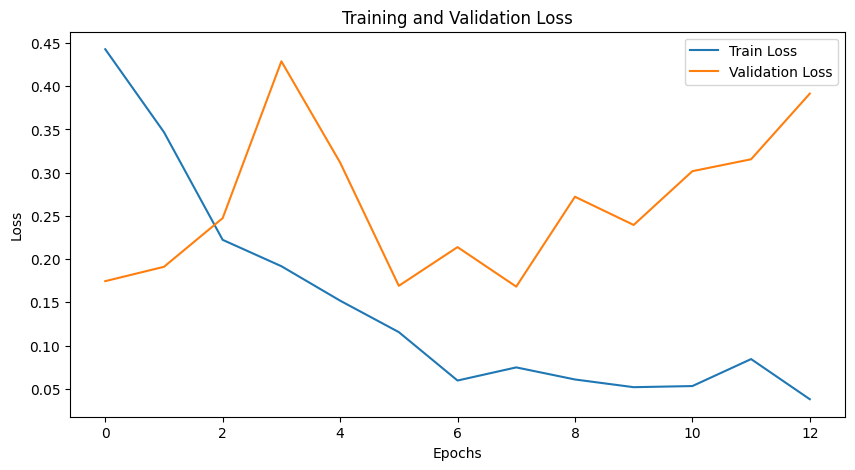

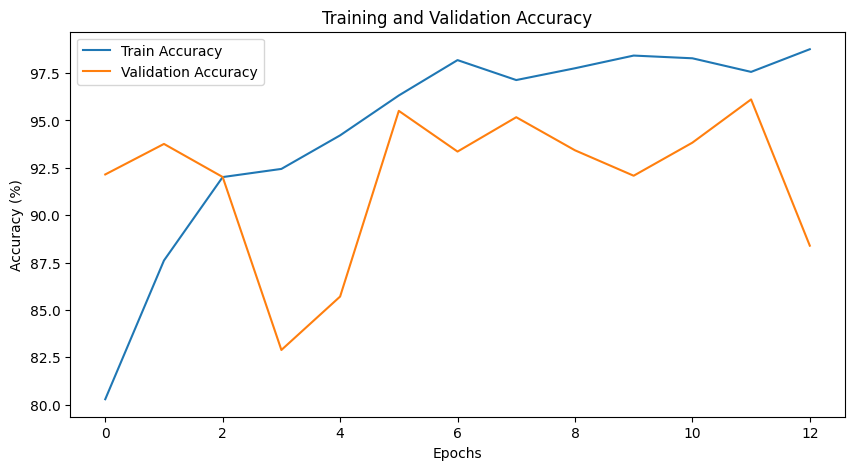

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.89      0.94      1431
     Class 1       0.22      0.76      0.34        59

    accuracy                           0.88      1490
   macro avg       0.60      0.83      0.64      1490
weighted avg       0.96      0.88      0.91      1490



CustomImageFeatureEfficientNet(
  (efficientnet): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
       

In [10]:
train_and_validate(model3,train_dataloader, val_dataloader, criterion, optimizer, epochs, device )